In [2]:
#%run -i helper.py

# Natural Gas Price Analysis

In [3]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from pathlib import Path
import yfinance as yf
from helper import *
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
from panel import widgets
import seaborn as sns
from MCForecastTools import MCSimulation
%matplotlib inline

import panel as pn
from ipywidgets import interact
import ipywidgets as widgets
import plotly.express as px
from sklearn.linear_model import LinearRegression
pn.extension('plotly')
import hvplot.pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
pn.extension()


In [4]:
# Load .env enviroment variables
load_dotenv()
eia_api_key = os.getenv("EIA_API_KEY")

# Set Start date and End Date
start_date = "2010-01-01"
end_date = "2014-12-30"


In [5]:
# fetch stock prices between start and end date using yfinance and convert to data frame
df_historic = yfinance_tickers_data("NG=F", start_date, end_date)
pn.Column(f"### Daily Closing Price of Natural Gas (NG=F) between {start_date} & {end_date}", pn.Row(df_historic.head(), width = 200), width = 900)


Column(width=900)
    [0] Markdown(str)
    [1] Row(width=200)
        [0] DataFrame(DataFrame)

In [6]:
# Read Natural Gas Storage Data
# set storage data file path
df_storage_file = Path(r"Data\NG_STOR_WKLY_S1_W.csv")
# Reading Storage data and convert it to dataframe
df_storage_data = pd.read_csv(df_storage_file,index_col="Date", infer_datetime_format=True, parse_dates=True)
display(pn.Row("### Weekly Storage of  Natural Gas Storage Data for US"))
df_storage_data.head()


Row
    [0] Markdown(str)

,48 States,East Region,Midwest Region,Mountain Region,Pacific Region,South Central,Salt South Central,Non Salt South Central
Date,,,,,,,,
2010-01-01,3117,769,900,195,268,985,159,826
2010-01-08,2850,703,820,185,257,886,123,763
2010-01-15,2607,642,750,176,246,793,91,702
2010-01-22,2521,616,710,171,235,789,102,687
2010-01-29,2406,582,661,164,221,779,108,671


In [7]:
# aggregate the weekly storage data into monthly, by averaging by month
df_storage_monthly_avg = format_strorage_monthly(df_storage_data)

pn.Column(f"### Monthly Natural Gas Storage Data by Region between {start_date} & {end_date}", df_storage_monthly_avg.head(), width = 900)
#display(pn.Row("###Monthly Natural Gas Storage Data by Region"))
#df_storage_monthly_avg.head()

Column(width=900)
    [0] Markdown(str)
    [1] DataFrame(DataFrame)

In [8]:
# Dictionary with ng comsumption settings, weather file names, and storage column names by US and states
region_info =  { "US" :
                {
                   "consumption" :  {"residential" : "NG.N3010US2.M", "industrial" : "NG.N3035US2.M" },
                   "weather_file" : r"",
                    "storage" :  "48 States"
                },  
    
                'PA' : 
                {
                   "consumption" :  {"residential" : "NG.N3010PA2.M", "industrial" : "NG.N3035PA2.M"},
                   "weather_file" : r"Data\Pittsburg_Area_Temp_2010-2014.csv",
                    "storage" :  r"East Region"
                },  
                 'CT' : {
                   "consumption" :  {"residential" : "NG.N3010CT2.M", "industrial" : "NG.N3035CT2.M"},
                    "weather_file": r"Data\Hartford_Area_Temp_2010-2014.csv",
                    "storage" : r"East Region"
                },
                 'IL' : {
                   "consumption" :  {"residential" : "NG.N3010IL2.M", "industrial" : "NG.N3035IL2.M"},
                    "weather_file": r"Data\Chicago_Area_Temp_2010-2014.csv",
                    "storage" : r"Midwest Region"
                },
                 'TX' : {
                   "consumption" :  {"residential" : "NG.N3010TX2.M", "industrial" : "NG.N3035TX2.M"},
                    "weather_file": r"Data\Dallas_Area_Temp_2010-2014.csv",
                    "storage" : r"South Central"
                },
                 'CA' : {
                   "consumption" :  {"residential" : "NG.N3010CA2.M", "industrial" : "NG.N3035CA2.M"},
                    "weather_file": r"Data\LosAngelus_Area_Temp_2010-2014.csv",
                    "storage" : r"Pacific Region"
                }                   
                
}

# init dictionary to store dataframes needed in this notebook
region_dfs = {}

#df_price_temperature = pd.DataFrame()

# Loop through the region_info dictionary and fetch data, cleanup and format data into various dataframes
for key, value in region_info.items():
    # init a dictionary for each key
    region_dfs[key] = {}
    
    # Fetch comumption data per region (key) both industrial and residential from EIA
    
    # Set residential series id
    series_id = region_info[key]["consumption"]["residential"]
    # Fetch residential data for region(key) from EIA
    df_res = eia_consumption_data_by_series_df(eia_api_key, series_id, key, "Residential", start_date, end_date)

    # Set Industrial series id
    series_id = region_info[key]["consumption"]["industrial"]
    # Fetch Industrial data for region(key) from EIA
    df_industrial = eia_consumption_data_by_series_df(eia_api_key, series_id, key, "Industrial", start_date, end_date)
    
    # Concat both data into a comsumption data frame
    df_comsumption = pd.concat((df_industrial, df_res), join="inner", axis=1 , sort=True).dropna()
    
    
    # Init the Storage data frame
    df_storage = pd.DataFrame()
    # Slice the regional storage data
    df_storage["Storage"] = df_storage_monthly_avg[region_info[key]["storage"]]
    
    
    # If region is US
    if key == "US":
        # Aggregrate the daily stock closing prices only as US has no weather into into monthly 
        df_avg_price = agg_stock_closing_price_monthly(df_historic)
        # Concat the stock price monly, conspumtion only and  storage monthly
        region_dfs[key]["combined"]  = pd.concat( [df_avg_price, df_comsumption, df_storage] ,
                                            join="inner", axis=1 , sort=True).dropna()

    else:
        # Get weather for region (using a city to represent a region/state)
        df_weather = weather_data(key, region_info[key]["weather_file"])
        
        # Set the weather data  for region
        #region_dfs[key]["weather"] = df_weather
        
        region_dfs[key]["price_temperature"] = pd.concat((df_historic, df_weather), join="inner", axis=1 , sort=True).dropna()
        # Aggegrate the stock prices and tempretaure into monthly values
        df_avg_price_temp =  agg_price_temperature_monthly(region_dfs[key]["price_temperature"])
        
        # Set the combined aggregated dataframes into one
        region_dfs[key]["combined"]  = pd.concat( [df_avg_price_temp, df_comsumption, df_storage ] ,
                                            join="inner", axis=1 , sort=True).dropna()

In [9]:
# Plot the closing price vs temperature
def plot_price_temperature(state, lag_price, lag_temperature, shift):
    
    # Get a copy data for the state
    df = region_dfs[state]["price_temperature"].copy()
    # reset index
    df = df.reset_index()
    # If shift, shift by -90 days
    if lag_temperature:
        df["Avg Temp"] = df["Avg Temp"].shift(periods=30 * shift)
    
    if lag_price:
        df["Close"] = df["Close"].shift(periods=30 * shift)
        
    # make the plot with secondary axis
    fig = make_subplots(rows=1, cols=1,
                    specs=[[{"secondary_y": True}],
                           ],  subplot_titles = [f" {state} Relationship between Daily Natural Gas Closing Prices & Avg Temperature"])
    # 1st Plot closing price vs time
    fig.add_trace(
        go.Scatter( x=df["Date"], y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=False
    )
    # 2nd Plot average temperarure as secondary y axes, ploted on the same plot
    fig.add_trace(
        go.Scatter( x=df["Date"], y=df["Avg Temp"], name="Average Temperature",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=True, )

   
    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    
    # Set layout properties
    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=10,
        t=60,
        pad=2
    )
    )
    # format x-axes
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df['Date'][0::28],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    #format y-axes
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    # return the figure
    return  fig

# Create the intercat panel for the plot
states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]
states = pn.widgets.Select(name='State', options=states_list)
price = pn.widgets.Checkbox(name='Lag Closing Price')
temperature = pn.widgets.Checkbox(name='Lag Temperature')
shift= pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)

interact_panel = pn.interact(plot_price_temperature, state = states, lag_price = price , lag_temperature = temperature,  shift = shift )
interact_panel
#print(interact_panel)
pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2], interact_panel[0][3], width=700, height=50), interact_panel[1][0])


Column
    [0] Row(height=50, sizing_mode='fixed', width=700)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Temperature')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive01488')

In [10]:
bShift = True
# Plot storage vs closing prices
def plot_storage_closingprice(region, lag_closing_price, lag_storage, shift):
    
    # fetch the data for the region
    df = region_dfs[region]["combined"].copy()  
    df = df.reset_index()
    
    # Shift storage ???
    if lag_storage:
        df["Storage"] = df["Storage"].shift(periods=shift)
    if lag_closing_price:
        df["Close"] = df["Close"].shift(periods=shift)        
    #display(df["Avg Temp"])
    fig = make_subplots(rows=1, cols=1,
                    specs=[[{"secondary_y": True}],
                           ],  subplot_titles = [f" {region} Monthly Relationship between Natural Gas Closing Price & Storage"])
    #display(df)
    # Top left
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Storage"], name="Monthly Storage",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Storage", secondary_y=True)
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    
    

    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=60,
        pad=4
    ),
    xaxis_tickformat = '%m-%Y'      
    )
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df['DATE'][0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig

states_list = list(region_info.keys())
wstates = pn.widgets.Select(name='State', options=states_list)
wprice = pn.widgets.Checkbox(name='Lag Closing Price')
wstorage = pn.widgets.Checkbox(name='Lag Storage')
wshift= pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)

interact_panel = pn.interact(plot_storage_closingprice, region = wstates, lag_closing_price = wprice , lag_storage = wstorage,  shift = wshift )
interact_panel
#print(interact_panel)
pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2], interact_panel[0][3], width=700, height=50), interact_panel[1][0])




Column
    [0] Row(height=50, sizing_mode='fixed', width=700)
        [0] Select(name='State', options=['US', 'PA', 'CT', ...], value='US')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive01502')

In [11]:
# Plot consumption vs price
def plot_comsumption_price_plotly(region, lag_price, lag_consumption, shift):
    #print(region)
    df = region_dfs[region]["combined"].copy()  
    
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
  
    str_res_title = f"{region} - Relationship b/w Closing Price & Resid. Consumption "
    str_indus_title = f"{region} - Relationship b/w Closing Price & Indus. Consumption"
    
    
    if lag_consumption:
        df[str_res] = df[str_res].shift(periods=3)
        df[str_indus] = df[str_indus].shift(periods=shift)
    if lag_price:
        df["Close"] = df["Close"].shift(periods=shift)

        
    
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res_title, str_indus_title])

    # Top left
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    # Top right
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)

    fig.add_trace(
        go.Scatter(x=df["DATE"], y =df["Close"], name="Closing Price", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Comsumption", secondary_y=True)
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=False)
    
    
    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1300,
    height=400
    
      
    )
    
    fig.update_layout(legend=dict(
    yanchor="top",
    y=1.5,
    xanchor="center",
    x=0.01
    ))
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df['DATE'][0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig


states_list = list(region_info.keys())
wstates = pn.widgets.Select(name='State', options=states_list)
wprice = pn.widgets.Checkbox(name='Lag Closing Price')
wcomsumption = pn.widgets.Checkbox(name='Lag Storage')
wshift= pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)

interact_panel = pn.interact(plot_comsumption_price_plotly , region=wstates, lag_price = wprice, lag_consumption = wcomsumption, shift = wshift) 

pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2], interact_panel[0][3], width=600, height=50), interact_panel[1][0])



Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='State', options=['US', 'PA', 'CT', ...], value='US')
        [1] Checkbox(name='Lag Closing Price')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive01516')

In [12]:
# Plot storage vs temperature
def plot_storage_temperature(state, lag_temperature, lag_storage, shift):
    # Fetch a copy of data for the state
    df = region_dfs[state]["combined"].copy()
    # reset index
    df = df.reset_index()
    
    # Shift temperarure by -3 months
    if lag_temperature:
        df["Avg Temp"] = df["Avg Temp"].shift(periods=shift)
    if lag_storage:    
        df["Storage"] = df["Storage"].shift(periods=shift)    
    # Create a single subplot
    fig = make_subplots(rows=1, cols=1,
                    specs=[[{"secondary_y": True}],
                           ],  subplot_titles = ["Relationship between NG Storage & Temperature"])
    
    # create the ave temp vs date - 1st plot on secondary y axis
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Avg Temp"], name="Average Temperature",  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=True )
    # create the storage vs date - 2nd plot on primary y axis
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=False
    )

    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    fig.update_yaxes(title_text="Storage", secondary_y=False)
    
    

    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",        
    autosize=False,
    width=1000,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=60,
        pad=4
    ),
    xaxis_tickformat = '%m-%Y'      
    )
    fig.update_xaxes(tickangle=90,
                 tickmode = 'array',
                 tickvals = df['DATE'][0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig



#interact_panel = pn.interact(plot_storage_temperature,state=list(region_info.keys())[-(len(region_info.keys()) - 1):]  )

states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]
wstates = pn.widgets.Select(name='State', options=states_list)
wtemp = pn.widgets.Checkbox(name='Lag Temperature')
wstorage = pn.widgets.Checkbox(name='Lag Storage')
wshift= pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)

interact_panel = pn.interact(plot_storage_temperature , state=wstates, lag_temperature = wtemp, lag_storage = wstorage, shift = wshift) 

pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2], interact_panel[0][3], width=600, height=50), interact_panel[1][0])






Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Checkbox(name='Lag Temperature')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive01530')

In [13]:
# Shift data to try to get a relationship
# Plot storage vs comsumption
def plot_storage_comnsumption(region, lag_consumption, lag_storage, shift):
    
    # fetch a copy of the region data
    df = region_dfs[region]["combined"].copy()
    
    # Names of residential and industrial column names
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
    
    # Set title for both plots
    str_res_title = f"{region} - Relationship between Res. Consumption & Storage"
    str_indus_title = f"{region} - Relationship between  Indus. Consumption & Storage"
    
    if lag_consumption:
    # Shift cpomsumption data by -3 months
        df[str_res] = df[str_res].shift(periods=shift)
        df[str_indus] = df[str_indus].shift(periods=shift)
    if lag_storage:
        df["Storage"] = df["Storage"].shift(periods=shift)
        
    
    # create 2 subplots one for residential, the other for Industrial
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res_title, str_indus_title])

    # 1st Plot - Residential
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    # 1st Plot - Storage on secondaru axes
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    # 2nd Plot - Industrial Consumption
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)
    # 2nd Plot - Storage Consumption
    fig.add_trace(
        go.Scatter(x=df["DATE"], y =df["Storage"], name="Storage", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Date")    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Comsumption", secondary_y=False)
    fig.update_yaxes(title_text="Storage", secondary_y=True)
    
    
    # Set Layout
    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1200,
    height=400
    
      
    )
    fig.update_layout(legend=dict(
    yanchor="top",
    y=1.5,
    xanchor="center",
    x=0.01
    ))    
    # update x & axes with ticks, tick format, tick lines
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df['DATE'][0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig

states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)
wconsumption = pn.widgets.Checkbox(name='Lag Consumption')
wstorage = pn.widgets.Checkbox(name='Lag Storage')
wshift= pn.widgets.IntSlider(name="Lag Period (in months)", start= -3, end=3, step=1, value=0)

interact_panel = pn.interact(plot_storage_comnsumption , region=wstates, lag_consumption = wconsumption, lag_storage = wstorage, shift = wshift) 

pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2], interact_panel[0][3], width=600,height=50), interact_panel[1][0])


#interact_panel = pn.interact(plot_storage_comnsumption,region=list(region_info.keys()), lag_consumption = False, lag_storage = False )

#pn.Column(pn.Row(interact_panel[0][0], interact_panel[0][1], interact_panel[0][2]), interact_panel[1][0])




Column
    [0] Row(height=50, sizing_mode='fixed', width=600)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Checkbox(name='Lag Consumption')
        [2] Checkbox(name='Lag Storage')
        [3] IntSlider(end=3, name='Lag Period (in months)', start=-3, value_throttled=0)
    [1] Plotly(Figure, name='interactive01544')

In [14]:
#region_dfs["CT"]["combined"].head()

In [15]:
# Plot consumption vs price
def plot_comsumption_temperaure_plotly(state):
    
    df = region_dfs[state]["combined"].copy()  
    #df.rename(columns = {"Average": "Avg Temp"}, inplace = True)
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
  
    str_res_title = f"{state} - Relationship b/w Resid. Consumption & Temperature"
    str_indus_title = f"{state} - Relationship b/w Indus. Consumption & Temperature"
    
    

    df[str_res] = df[str_res] #.shift(periods=-3)
    df[str_indus] = df[str_indus] #.shift(periods=-3)
    
    
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{"secondary_y": True} , {"secondary_y": True}],
                           ],  subplot_titles = [str_res_title, str_indus_title])

    # Top left
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_res], name=str_res,  line=dict(color="#ff0000")),
        row=1, col=1, secondary_y=False, )

    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df["Avg Temp"], name="Temperature", line=dict(color="#0000ff")),
        row=1, col=1, secondary_y=True
    )

    # Top right
    fig.add_trace(
        go.Scatter( x=df["DATE"], y=df[str_indus], name=str_indus , line=dict(color="#007f00")),
        row=1, col=2, secondary_y=False)

    fig.add_trace(
        go.Scatter(x=df["DATE"], y =df["Avg Temp"], name="Temperature", line=dict(color="#0000ff")),
        row=1, col=2, secondary_y=True
    )
    
    # Set x-axis title
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Milliopn Cubic Feet - Comsumption", secondary_y=False)
    fig.update_yaxes(title_text="Temperature °F", secondary_y=True)
    
    
    fig.update_layout(
    plot_bgcolor = "rgb(255,255,255)",
    autosize=True,
    width=1500,
    height=400
    
      
    )
    
    fig.update_layout(legend=dict(
    yanchor="top",
    y=1.5,
    xanchor="center",
    x=0.01
    ))
    
    fig.update_xaxes(tickangle=90, matches='x', title_text="Date", 
                 tickmode = 'array',
                 tickvals = df['DATE'][0::2],
                 tickformat = '%m-%Y', showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes( showgrid= False, ticks="inside", showline=True, linewidth=2, linecolor='black')

    
    return  fig


states = list(region_info.keys())[-(len(region_info.keys()) - 1):]

interact_panel = pn.interact(plot_comsumption_temperaure_plotly,region=states, state = states )

pn.Column(pn.Row(interact_panel[0][0]), interact_panel[1][0])



Column
    [0] Row
        [0] Select(name='state', options=['PA', 'CT', 'IL', ...], value='PA')
    [1] Plotly(Figure, name='interactive01554')

In [16]:
#region_dfs["US"]["combined"] 

In [17]:
# Compute the corelation between all data per region
def compute_correlation(state, lag_temperature, lag_storage, lag_comsumption, include_price , include_temperature , include_storage , include_comsumption ):
    
    str_indus = "Industrial Consumption"
    str_res = "Residential Consumption" 
  
    df = pd.DataFrame()
    if include_price:
        df["Close"] = region_dfs[state]["combined"]["Close"]
    if state != "US" and include_temperature:
        df["Avg Temp"] = region_dfs[state]["combined"]["Avg Temp"]
    if  include_storage:    
        df["Storage"] = region_dfs[state]["combined"]["Storage"]
    if include_comsumption:
        df[str_res] = region_dfs[state]["combined"][str_res]        
        df[str_indus] = region_dfs[state]["combined"][str_indus]    
      
    df = df.pct_change().dropna()
    
    #df = region_dfs[state]["combined"].copy() 
    
    #df.reset_index(inplace = True)
    #df = df.set_index("DATE")
    #display(df)
        
        
    if state != "US" and include_temperature and lag_temperature:
            df["Avg Temp"] = df["Avg Temp"].shift(3)

    if include_comsumption and lag_comsumption:    
        df[str_res] = df[str_res].shift(3)
        df[str_indus] = df[str_indus].shift(3)
    if include_storage and lag_storage:
        df["Storage"] = df["Storage"].shift(3)
        
    correlation = df.corr()

    return correlation
    

states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)
wtemp = pn.widgets.Checkbox(name='Lag Temperature')
wconsumption = pn.widgets.Checkbox(name='Lag Consumption')
wstorage = pn.widgets.Checkbox(name='Lag Storage')

winclude_price = pn.widgets.Checkbox(name='Include Price', value=True)
winclude_temp = pn.widgets.Checkbox(name='Include Temperature')
winclude_consumption = pn.widgets.Checkbox(name='Include Consumption', value= True)
winclude_storage = pn.widgets.Checkbox(name='Include Storage', value = True)



interact_panel2 =pn.interact(compute_correlation,state=wregion, 
                             lag_temperature = wtemp, lag_storage = wstorage, lag_comsumption = wconsumption,
                            include_price = winclude_price, include_temperature = winclude_temp, include_storage = winclude_storage, include_comsumption = winclude_consumption)

#pn.Column(interact_panel2[0][0], interact_panel2[1][0], scroll=False, width=500)
pn_widgets = pn.Row(pn.Column(interact_panel2[0][0]), pn.Column(pn.Row(interact_panel2[0][1],interact_panel2[0][2],interact_panel2[0][3], width=600),
          pn.Row(interact_panel2[0][4],interact_panel2[0][5],interact_panel2[0][6], interact_panel2[0][7], width=600)))
pn.Column( "####Regional Correlation Matrix b/w Closing Price, Comsumption, Storage and Average Temperature(if applicable)",
        pn_widgets, "<br/>", interact_panel2[1][0], scroll=False)


Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
        [1] Column
            [0] Row(width=600)
                [0] Checkbox(name='Lag Temperature')
                [1] Checkbox(name='Lag Storage')
                [2] Checkbox(name='Lag Consumption')
            [1] Row(width=600)
                [0] Checkbox(name='Include Price', value=True)
                [1] Checkbox(name='Include Temperature')
                [2] Checkbox(name='Include Storage', value=True)
                [3] Checkbox(name='Include Consumption', value=True)
    [2] Markdown(str)
    [3] DataFrame(DataFrame, name='interactive01573')

In [18]:
def show_plot_correlation(state, lag_temperature, lag_storage, lag_comsumption, include_price , include_temperature , include_storage , include_comsumption):
    stitle = f" Corelation for {state}"
    correlation = compute_correlation(state, lag_temperature, lag_storage, lag_comsumption, include_price , include_temperature , include_storage , include_comsumption )
    hmap = correlation.hvplot.heatmap( height=500, width=700, colorbar=True , cmap="fire", title=stitle,  clim=(-1,1))
    return hmap

states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)
wtemp = pn.widgets.Checkbox(name='Lag Temperature')
wconsumption = pn.widgets.Checkbox(name='Lag Consumption')
wstorage = pn.widgets.Checkbox(name='Lag Storage')

winclude_price = pn.widgets.Checkbox(name='Include Price', value=True)
winclude_temp = pn.widgets.Checkbox(name='Include Temperature')
winclude_consumption = pn.widgets.Checkbox(name='Include Consumption', value= True)
winclude_storage = pn.widgets.Checkbox(name='Include Storage', value = True)



interact_panel =pn.interact(show_plot_correlation,state=wregion, 
                             lag_temperature = wtemp, lag_storage = wstorage, lag_comsumption = wconsumption,
                            include_price = winclude_price, include_temperature = winclude_temp, include_storage = winclude_storage, include_comsumption = winclude_consumption)



pn_widgets = pn.Row(pn.Column(interact_panel[0][0]), pn.Column(pn.Row(interact_panel[0][1],interact_panel[0][2],interact_panel[0][3], width=600),
          pn.Row(interact_panel[0][4],interact_panel[0][5],interact_panel[0][6], interact_panel[0][7], width=600)))
pn.Column( "####Regional Correlation b/w Closing Price, Comsumption, Storage and Average Temperature(if applicable)",
        pn_widgets, "<br/>", interact_panel[1][0], scroll=False)



Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Select(name='Region', options=['US', 'PA', 'CT', ...], value='US')
        [1] Column
            [0] Row(width=600)
                [0] Checkbox(name='Lag Temperature')
                [1] Checkbox(name='Lag Storage')
                [2] Checkbox(name='Lag Consumption')
            [1] Row(width=600)
                [0] Checkbox(name='Include Price', value=True)
                [1] Checkbox(name='Include Temperature')
                [2] Checkbox(name='Include Storage', value=True)
                [3] Checkbox(name='Include Consumption', value=True)
    [2] Markdown(str)
    [3] HoloViews(HeatMap, name='interactive01599')

In [19]:


def linear_regression(x, y, shift_period = -60):
    # Linear regresssion with temp and natural gas prices
    # Pull out average temp and natural gas closing price from the df
    if shift_period != 0:
        x = x.shift(periods=shift_period).dropna()
    y = y.iloc[0: len(x)]
    #drop the index from both so the arrays are 1-dimensional
    x.reset_index(drop=True, inplace=True)
    x.reset_index(drop=True, inplace=True)
    #assign independent variable (x) and dependent variable (y) to the proper dataframe
    #reshape the data frames to pandas arrays
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    #print(X)
    #create the model and fit it to the data
    model = LinearRegression()
    model.fit(x,y)
    r_sq = model.score(x,y)
    #print("Coefficient of determination", r_sq)
    #print("Slope", model.coef_)
    #print("Intercept", model.intercept_)
    y_pred = model.predict(x)
    #print("Predicted response:", y_pred, sep='\n')
    return r_sq, model, y_pred
    
    
str_res = "Residential Consumption"
for key, value in region_dfs.items():
    if key != "US":
    
        df = region_dfs[key]["price_temperature"].copy()
        #print(f"\n----------{key} - Avg Temp - Close ------------------")
        r_sq, linear_model, y_pred = linear_regression(df["Avg Temp"], df["Close"], shift_period =-90)
        #print("Coefficient of determination", r_sq)
        #print("Slope", linear_model.coef_)
        #print("Intercept", linear_model.intercept_)
        #print("Predicted response:", y_pred, sep='\n')
        
        linear_reg = pd.DataFrame()
        
        #linear_reg["Coefficient"] =  '3' #r_sq
        
        linear_reg["Slope"] = linear_model.coef_
        linear_reg["Intercept"] = linear_model.intercept_
        linear_reg["Coefficient  of determination"] =  r_sq
        linear_reg = linear_reg[['Coefficient  of determination', 'Intercept', 'Slope']]
        
        predic_response = pd.DataFrame(list(y_pred))
        #display(linear_reg)
        
        region_dfs[key]["temp_close_lin_reg"] = linear_reg
        region_dfs[key]["temp_close_predic_response"] = predic_response
        region_dfs[key]["temp_close_lin_reg_model"] = linear_model
        
        df = region_dfs[key]["combined"].copy()
        #display( df[str_res])
        #df_avg_month_temp = df["Avg Temp"]
        #df_consumption = df[str_res]
        r_sq, linear_model, y_pred = linear_regression(df["Avg Temp"], df[str_res], shift_period =0)
        
        linear_reg = pd.DataFrame()
        linear_reg["Slope"] = linear_model.coef_
        linear_reg["Intercept"] = linear_model.intercept_
        linear_reg["Coefficient  of determination"] =  r_sq
        linear_reg = linear_reg[['Coefficient  of determination', 'Intercept', 'Slope']]
        #linear_reg["state"] = key
        
        predic_response = pd.DataFrame(list(y_pred))
        #display(linear_reg)
        region_dfs[key]["temp_res_consump_lin_reg"] = linear_reg
        region_dfs[key]["temp_res_consump_predic_response"] = predic_response
        region_dfs[key]["temp_res_consump_lin_reg_model"] = linear_model
        #print("Coefficient of determination", r_sq)
        #print("Slope", linear_model.coef_)
        #print("Intercept", linear_model.intercept_)
        #print("Predicted response:", y_pred, sep='\n')
        
        
   # else:




In [20]:
print(f"\n\n")
for key, value in region_dfs.items():
    
    if key != "US":
        #print(f"\n----------{key} - % Change Avg Temp - Close ------------------")
        df = region_dfs[key]["price_temperature"].copy()
        df_pct_change = df.pct_change().dropna()
        r_sq, linear_model, y_pred = linear_regression(df["Avg Temp"], df["Close"], shift_period =-90)
        #r_sq, linear_model, y_pred = linear_regression(df["Avg Temp"], df["Close"], shift_period =-90)
        #print("Coefficient of determination", r_sq)
        #print("Slope", linear_model.coef_)
        #print("Intercept", linear_model.intercept_)
        #print("Predicted response:", y_pred, sep='\n')
        
        linear_reg["Slope"] = linear_model.coef_
        linear_reg["Intercept"] = linear_model.intercept_
        linear_reg["Coefficient  of determination"] =  r_sq
        linear_reg = linear_reg[['Coefficient  of determination', 'Intercept', 'Slope']]
        
        predic_response = pd.DataFrame(list(y_pred))
        #display(linear_reg)
       
        #linear_reg = linear_reg[['x', 'y', 'a', 'b']]
        
        predic_response = pd.DataFrame(list(y_pred))
       
        
        region_dfs[key]["pct_temp_close_lin_reg"] = linear_reg
        region_dfs[key]["pct_temp_close_predic_response"] = predic_response
        
        

In [21]:
# Compute the corelation between all data per region
def show_linear_reg_temp_close(state):
    lin_reg = region_dfs[state]["temp_close_lin_reg"].style.hide_index()

    return lin_reg
    


states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]  

#states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)

interact_panel = pn.interact(show_linear_reg_temp_close, state = wregion  )

#interact_panel
pn.Column( "####Linear Regression between Avg Temperature and Closing Price",
        pn.Column(interact_panel[0][0], "<br/>", interact_panel[1][0], scroll=False, width=700))


Column
    [0] Markdown(str)
    [1] Column(width=700)
        [0] Select(name='Region', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Markdown(str)
        [2] HTML(Styler, name='interactive01773')

In [22]:
# Compute the corelation between all data per region
def show_linear_pct_reg_temp_close(state):
    lin_reg = region_dfs[state]["pct_temp_close_lin_reg"].style.hide_index()

    return lin_reg
    



states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]  

#states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)

interact_panel = pn.interact(show_linear_pct_reg_temp_close, state = wregion  )

#interact_panel


pn.Column( "####Linear Regression between Percent Change of Avg Temperature and Closing Price",
        pn.Column(interact_panel[0][0], "<br/>", interact_panel[1][0], scroll=False, width=700))


Column
    [0] Markdown(str)
    [1] Column(width=700)
        [0] Select(name='Region', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Markdown(str)
        [2] HTML(Styler, name='interactive01788')

In [23]:
# Compute the corelation between all data per region
def show_linear_temp_res_consump(state):
    lin_reg = region_dfs[state]["temp_res_consump_lin_reg"].style.hide_index()

    return lin_reg
    



states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]  

#states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='Region', options=states_list)

interact_panel = pn.interact(show_linear_temp_res_consump, state = wregion  )

#interact_panel
pn.Column(interact_panel[0][0], interact_panel[1][0], scroll=False, width=500)

pn.Column( "####Linear Regression between  Avg Temperature and Residential Comsumption",
        pn.Column(interact_panel[0][0], "<br/>", interact_panel[1][0], scroll=False, width=700))


Column
    [0] Markdown(str)
    [1] Column(width=700)
        [0] Select(name='Region', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Markdown(str)
        [2] HTML(Styler, name='interactive01803')

In [24]:
#Regression with weather and storage
#bring in storage data 
storage_df = df_storage_data.copy()

#group storage data by year and month, then get the sum for the month
df_sum_month_storage = storage_df.groupby(by=[storage_df.index.year, storage_df.index.month]).sum()

df_60_month_storage = df_sum_month_storage.iloc[0:57]
#len(df_60_month_storage)

def linear_regression_storage_temp(state):
    

    #pull storage of lower 48 out of the df
    national_storage_df = df_60_month_storage[region_info[state]["storage"]]
    #national_storage_df = df_60_month_storage["48 States"]
    #display(national_storage_df)

    #drop the index from national storage so it's 1-dimensional
    national_storage_df.reset_index(drop=True, inplace=True)
    #display(national_storage_df.head())
    #national_storage_df.head()
    #shift temp data to see if there's a relationship

    df_avg_month_temp = region_dfs[state]["combined"].copy()["Avg Temp"]
    #display(df_avg_month_temp)
    #df_avg_month_temp = df["Avg Temp"]
    df_shift_month = df_avg_month_temp.shift(periods=-3).dropna()
    r_sq, linear_model, y_pred = linear_regression(df_shift_month, national_storage_df, shift_period =0)
    linear_reg = pd.DataFrame()
        
    #linear_reg["Coefficient"] =  '3' #r_sq

    linear_reg["Slope"] = linear_model.coef_
    linear_reg["Intercept"] = linear_model.intercept_
    linear_reg["Coefficient  of determination"] =  r_sq
    linear_reg = linear_reg[['Coefficient  of determination', 'Intercept', 'Slope']]

    return linear_reg.style.hide_index()

states_list = list(region_info.keys())[-(len(region_info.keys()) - 1):]  

#states_list = list(region_info.keys())
wregion = pn.widgets.Select(name='State', options=states_list)

states = list(region_info.keys())[-(len(region_info.keys()) - 1):]      
interact_panel = pn.interact(linear_regression_storage_temp, state = wregion  )

pn.Column( "####Linear Regression between Storage  and Avg Temperature",
        pn.Column(interact_panel[0][0], "<br/>", interact_panel[1][0], scroll=False, width=700))



Column
    [0] Markdown(str)
    [1] Column(width=700)
        [0] Select(name='State', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Markdown(str)
        [2] HTML(Styler, name='interactive01819')

In [25]:
#Regression with weather and storage
#bring in storage data 
storage_df = df_storage_data.copy()

#group storage data by year and month, then get the sum for the month
df_sum_month_storage = storage_df.groupby(by=[storage_df.index.year, storage_df.index.month]).sum()

df_60_month_storage = df_sum_month_storage.iloc[0:57]
#len(df_60_month_storage)

def linear_regression_storage_temp(state):
    

    #pull storage of lower 48 out of the df
    national_storage_df = df_60_month_storage[region_info[state]["storage"]]
    #national_storage_df = df_60_month_storage["48 States"]
    #display(national_storage_df)

    #drop the index from national storage so it's 1-dimensional
    national_storage_df.reset_index(drop=True, inplace=True)
    #display(national_storage_df.head())
    #national_storage_df.head()
    #shift temp data to see if there's a relationship

    df_avg_month_temp = region_dfs[state]["combined"].copy()["Avg Temp"]
    #display(df_avg_month_temp)
    #df_avg_month_temp = df["Avg Temp"]
    df_shift_month = df_avg_month_temp.shift(periods=-3).dropna()
    r_sq, linear_model, y_pred = linear_regression(df_shift_month, national_storage_df, shift_period =0)
    linear_reg = pd.DataFrame()
        
    #linear_reg["Coefficient"] =  '3' #r_sq

    linear_reg["Slope"] = linear_model.coef_
    linear_reg["Intercept"] = linear_model.intercept_
    linear_reg["Coefficient  of determination"] =  r_sq
    linear_reg = linear_reg[['Coefficient  of determination', 'Intercept', 'Slope']]

    return linear_reg.style.hide_index()
 
states = list(region_info.keys())[-(len(region_info.keys()) - 1):]      
interact_panel = pn.interact(linear_regression_storage_temp, state = states  )

pn.Column( "####Linear Regression between Storage  and Avg Temperature",
        pn.Column(interact_panel[0][0], "<br/>", interact_panel[1][0], scroll=False, width=700))



Column
    [0] Markdown(str)
    [1] Column(width=700)
        [0] Select(name='state', options=['PA', 'CT', 'IL', ...], value='PA')
        [1] Markdown(str)
        [2] HTML(Styler, name='interactive01833')

In [26]:
#Test the Pittsburg model with out of sample data
#Import Pittsburg model with Pittsburg temp data 2015-2019 
df_non_sample_temp = weather_data("PA", r"Data\Pittsburg_Temp_2015_2019.csv")

df_non_sample_temp = agg_temperature_monthly(df_non_sample_temp)

df_avg_non_sample_temp = df_non_sample_temp["Avg Temp"]
df_non_sample_temp.reset_index(drop=True, inplace=True)


new_data = df_non_sample_temp
#display(df_non_sample_temp.head())

df = region_dfs["PA"]["combined"].copy()
r_sq, linear_model, y_pred = linear_regression(df["Avg Temp"], df[str_res], shift_period =0)

new_x = np.array(new_data["Avg Temp"]).reshape(-1,1)
#display(new_x)
y_new_pred = linear_model.predict(new_x)
y_new_pred
#index = 
future_predic_response = pd.DataFrame(y_new_pred, columns=["Predicted Consumption"])
future_predic_response.head().style.hide_index()


Predicted Consumption
45033.526306
51795.668240
33538.643388
21226.000532
11596.440774


In [27]:
start_date_2 = "2015-01-01"
end_date_2 = "2019-12-30"
pa_series_id = "NG.N3010PA2.M"

df_out_sample_comsumption = eia_consumption_data_by_series_df(eia_api_key, pa_series_id, key, "Residential", start_date_2, end_date_2, drop_date = False)
df_out_sample_comsumption= df_out_sample_comsumption.sort_values(by="DATE", ascending = True)
df_out_sample_comsumption.drop(columns="DATE", inplace = True)
df_out_sample_comsumption =  df_out_sample_comsumption.reset_index()
#display(df_out_sample_comsumption)
df_out_sample_combined = pd.concat((df_out_sample_comsumption, future_predic_response), join="inner", axis=1, sort=True)
#df_out_sample_combined.head()

df_out_sample_combined.style.hide_index()


pn.Column( "### Out of Sample Analysis", df_out_sample_combined.style.hide_index(), scroll=False, width=1000 )

Column(width=1000)
    [0] Markdown(str)
    [1] HTML(Styler)

In [38]:
df_out_sample_combined.hvplot(title="Out of Sample Analysis", width=900)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## 5 year Monte Carlo Simulation of Natural Gas Prices and Analysis of Actual Gas Price at the end  of 5 Years

In [28]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Data has AGG first and then SPY, so the weights have to be [.40, .60]
start_date2 = "2015-01-01"
end_date2 = "2019-12-31"
df_historic2015_2019 = yfinance_tickers_data("NG=F", start_date2, end_date2, drop_extra_cols = True )


df = pd.concat((df_historic, df_historic), join="inner", axis=1 , sort=True, keys=["NG"]).dropna()
df = df.rename(columns = {"Close": "close"})
df.head()

,NG
,close
Date,
2010-01-04,5.884
2010-01-05,5.637
2010-01-06,6.009
2010-01-07,5.806
2010-01-08,5.749


In [29]:
df_historic2015_2019

,Close
Date,
2015-01-02,3.003
2015-01-05,2.882
2015-01-06,2.938
2015-01-07,2.871
2015-01-08,2.927
...,...
2019-12-23,2.214
2019-12-26,2.294
2019-12-27,2.158


In [30]:
nsim = 500
port_weights = [1]
years = 5

MC_stock_dist = MCSimulation(
    portfolio_data = df, 
    weights = port_weights, 
    num_simulation = nsim,
    num_trading_days = 252 * 5
    ) 
MC_stock_dist.portfolio_data.head()


NG             
            close daily_return
Date                          
2010-01-04  5.884          NaN
2010-01-05  5.637    -0.041978
2010-01-06  6.009     0.065993
2010-01-07  5.806    -0.033783
2010-01-08  5.749    -0.009817

In [31]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stock_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004242,1.002662,1.031685,1.027477,1.035429,1.006829,1.066986,0.983946,0.980726,0.973134,...,0.982476,0.983075,0.986415,0.962004,1.009678,0.999147,1.036972,0.997953,0.960980,1.007578
2,0.968290,1.015305,1.023960,1.011106,1.036802,0.997603,1.097864,0.958662,0.946912,0.980249,...,0.958315,0.991792,0.963581,0.958250,0.976980,1.032298,1.034245,0.972262,0.953785,1.050802
3,0.970173,0.998883,1.004266,1.011867,1.024786,0.940601,1.117478,1.015480,0.946135,0.904097,...,0.952110,0.952360,0.971659,0.974351,0.953980,1.018565,1.003796,0.947142,1.008454,1.008867
4,1.024939,0.978485,1.034525,1.051427,1.032050,0.934142,1.122886,0.990678,0.883691,0.945053,...,0.955385,0.954242,0.983140,0.979360,0.980220,1.070145,0.982566,0.939538,0.997483,1.041936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.195757,1.666764,0.111205,1.375774,2.077794,0.127015,0.695706,0.884255,0.818202,1.285711,...,2.123683,0.509578,0.097325,0.202016,0.387302,0.200727,0.714048,0.262301,0.489634,0.302180
1257,0.199638,1.652373,0.110564,1.369011,2.021717,0.125082,0.688798,0.891328,0.832245,1.272456,...,2.160922,0.523584,0.095742,0.202861,0.385968,0.199748,0.690202,0.268557,0.492466,0.289773
1258,0.194332,1.524611,0.110252,1.327423,1.964454,0.124219,0.686303,0.886278,0.835986,1.220805,...,2.149754,0.514499,0.095760,0.200485,0.386481,0.201214,0.704018,0.272549,0.506215,0.284955
1259,0.185830,1.468090,0.108843,1.381002,2.034895,0.124904,0.713906,0.875376,0.804922,1.166830,...,2.097081,0.526011,0.092925,0.204681,0.390881,0.188441,0.707865,0.276760,0.494121,0.282570


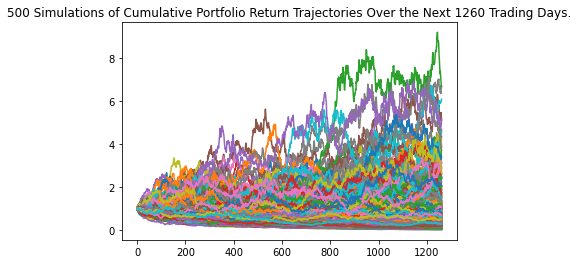

In [32]:
# Plot Simulation
dist_plot = MC_stock_dist.plot_simulation()

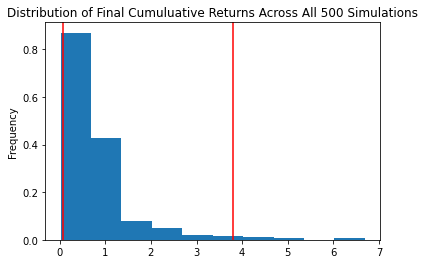

In [33]:
# Plot probability distribution and confidence intervals
dist_plot = MC_stock_dist.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
stocks_tbl = MC_stock_dist.summarize_cumulative_return()
# Print summary statistics
print(stocks_tbl)

count           500.000000
mean              0.824974
std               0.937811
min               0.019604
25%               0.257155
50%               0.572643
75%               0.998263
max               6.687849
95% CI Lower      0.075115
95% CI Upper      3.803484
Name: 1260, dtype: float64


In [35]:
MC_stock_dist.simulated_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004242,1.002662,1.031685,1.027477,1.035429,1.006829,1.066986,0.983946,0.980726,0.973134,...,0.982476,0.983075,0.986415,0.962004,1.009678,0.999147,1.036972,0.997953,0.960980,1.007578
2,0.968290,1.015305,1.023960,1.011106,1.036802,0.997603,1.097864,0.958662,0.946912,0.980249,...,0.958315,0.991792,0.963581,0.958250,0.976980,1.032298,1.034245,0.972262,0.953785,1.050802
3,0.970173,0.998883,1.004266,1.011867,1.024786,0.940601,1.117478,1.015480,0.946135,0.904097,...,0.952110,0.952360,0.971659,0.974351,0.953980,1.018565,1.003796,0.947142,1.008454,1.008867
4,1.024939,0.978485,1.034525,1.051427,1.032050,0.934142,1.122886,0.990678,0.883691,0.945053,...,0.955385,0.954242,0.983140,0.979360,0.980220,1.070145,0.982566,0.939538,0.997483,1.041936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.195757,1.666764,0.111205,1.375774,2.077794,0.127015,0.695706,0.884255,0.818202,1.285711,...,2.123683,0.509578,0.097325,0.202016,0.387302,0.200727,0.714048,0.262301,0.489634,0.302180
1257,0.199638,1.652373,0.110564,1.369011,2.021717,0.125082,0.688798,0.891328,0.832245,1.272456,...,2.160922,0.523584,0.095742,0.202861,0.385968,0.199748,0.690202,0.268557,0.492466,0.289773
1258,0.194332,1.524611,0.110252,1.327423,1.964454,0.124219,0.686303,0.886278,0.835986,1.220805,...,2.149754,0.514499,0.095760,0.200485,0.386481,0.201214,0.704018,0.272549,0.506215,0.284955
1259,0.185830,1.468090,0.108843,1.381002,2.034895,0.124904,0.713906,0.875376,0.804922,1.166830,...,2.097081,0.526011,0.092925,0.204681,0.390881,0.188441,0.707865,0.276760,0.494121,0.282570


In [36]:
ci_lower = round(stocks_tbl[8],2)
ci_upper = round(stocks_tbl[9],2)

price_od_NG_on_last_day = df_historic["Close"][-1]

lower_value = ci_lower * df_historic2015_2019["Close"][-1] 
upper_value = ci_upper * df_historic2015_2019["Close"][-1] 


sinfo = f"####There is a 95% chance that an initial investment of ${price_od_NG_on_last_day:,.2f} in the portfolio over the next 5 years will end within in the range of"f" ${lower_value:,.2f} and ${upper_value:,.2f}"


pn.Column(sinfo , scroll=False, width=700)



Column(width=700)
    [0] Markdown(str)

In [37]:
start_date2 = "2015-01-01"
end_date2 = "2019-12-31"
df_historic2015_2019 = yfinance_tickers_data("NG=F", start_date2, end_date2, drop_extra_cols = True )
price_at_out_of_sample = df_historic2015_2019["Close"][-1]

sconclusion = f"###The price of Natural Gas Stock at the end of 5 year out of sample data is ${price_at_out_of_sample:,.2f}  and it falls within in the range of "f" ${lower_value:,.2f} 95% lower and ${upper_value:,.2f} 95% upper confidence level."

pn.Column(sconclusion , scroll=False, width=700)

Column(width=700)
    [0] Markdown(str)